In [84]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt


In [85]:
model = pybamm.BaseModel()


In [86]:
c = pybamm.Variable("c", domain="unit line")


In [87]:
D = c * (1 - c)  # diffusion coefficient
omega = pybamm.Scalar(0.5)  # enthalpy of mixing per site
mu = pybamm.log(c / (1 - c)) + omega * (1 - 2 * c)  # chemical potential
N = pybamm.grad(mu)


In [88]:
dcdt = pybamm.div(D * N)


In [89]:
model.rhs = {c: dcdt}


In [90]:
model.boundary_conditions = {
    c: {"left": (0, "Neumann"), "right": (0, "Neumann")},
    # need to provide boundary conditions for whatever is inside the gradient
    # note: these conditions are wrong, replace with correct ones
    mu: {"left": (0, "Dirichlet"), "right": (0, "Dirichlet")},
}


In [91]:
x = pybamm.SpatialVariable("x", domain="unit line")
model.initial_conditions = {c: 0.3 * pybamm.tanh(10 * (x - 0.5)) + 0.5}


In [92]:
model.variables = {"c": c}


In [93]:
# define geometry
geometry = {"unit line": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}


In [94]:
# mesh and discretise
submesh_types = {"unit line": pybamm.Uniform1DSubMesh}
var_pts = {x: 101}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)


In [95]:
spatial_methods = {"unit line": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)


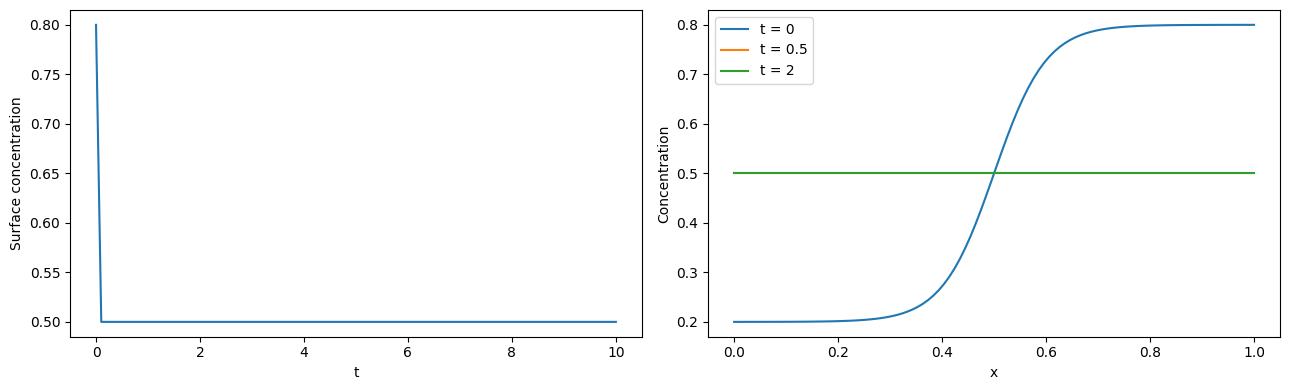

In [96]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 10, 100)
solution = solver.solve(model, t)

# post-process, so solution can be called at any time t or space x
c = solution["c"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, x=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")
x = np.linspace(0, 1, 100)
ax2.plot(x, c(t=0, x=x), label="t = 0")
ax2.plot(x, c(t=0.5, x=x), label="t = 0.5")
ax2.plot(x, c(t=2, x=x), label="t = 2")
ax2.set_xlabel("x")
ax2.set_ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.show()
